# Notebook 3: Cell Type Annotation & Export

**Cell Annotation Pipeline - Part 3 of 3**

**Stages:** 8-9
**📥 Input:** `outputs/clustered_data.h5ad`
**📤 Output:** `outputs/annotated_data.h5ad` (FINAL)

---

In [ ]:
# ============================================================================
# RECLUSTERING PARAMETERS
# ============================================================================
RECLUSTERING_PARAMS={
    'enable': True,                     # 🔧 Set to True to enable re-clustering
    'n_top_genes': 3000,                 # 🔧 HVGs for neuron subsets
    'n_pcs': 30,                         # 🔧 PCs for neuron subsets
    'n_neighbors': 15,                   # 🔧 kNN neighbors
    'auto_resolution': True,             # 🔧 Auto-select resolution (recommended)
    'resolution_grid': None,             # 🔧 Custom resolutions to test (None = default)
    'random_state': 0,                   # Random seed for reproducibility
    'write_h5ad': True,                  # 🔧 Save subset h5ad files
    
    # NEW: Improved subtype assignment parameters
    'use_cluster_assignment': True,      # 🔧 Assign subtypes at cluster level (RECOMMENDED)
                                         #    True = respects UMAP structure (better alignment)
                                         #    False = per-cell assignment (old behavior)
    'confidence_margin': 0.05,           # 🔧 Minimum score difference to assign subtype
                                         #    Higher = more conservative, fewer cells assigned
}

print("Re-clustering configuration:")
print(f"  Enabled: {RECLUSTERING_PARAMS['enable']}")
if RECLUSTERING_PARAMS['enable']:
    print(f"  HVGs: {RECLUSTERING_PARAMS['n_top_genes']}")
    print(f"  PCs: {RECLUSTERING_PARAMS['n_pcs']}")
    print(f"  Auto-resolution: {RECLUSTERING_PARAMS['auto_resolution']}")
    print(f"  Cluster-based assignment: {RECLUSTERING_PARAMS['use_cluster_assignment']}")
    print(f"  Confidence margin: {RECLUSTERING_PARAMS['confidence_margin']}")



Re-clustering configuration:
  Enabled: True
  HVGs: 3000
  PCs: 30
  Auto-resolution: True
  Cluster-based assignment: True
  Confidence margin: 0.05


In [ ]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Load
print("Loading data from Notebook 2...")
adata = sc.read_h5ad('outputs/clustered_data.h5ad')

# Validate
checks = {
    'UMAP': 'X_umap' in adata.obsm,
    'Clusters': 'leiden' in adata.obs.columns,
    'Markers': 'rank_genes_groups' in adata.uns,
}

for check, passed in checks.items():
    print(f"  {'✓' if passed else '✗'} {check}")
    if not passed:
        raise ValueError(f"Missing {check} - run Notebook 2!")

print(f"\n✓ Loaded: {adata.n_obs:,} cells, {adata.obs['leiden'].nunique()} clusters")

Loading data from Notebook 2...
  ✓ UMAP
  ✓ Clusters
  ✓ Markers

✓ Loaded: 16,188 cells, 21 clusters


## Parameter Configuration

Define marker genes and annotation parameters.

In [ ]:
# ============================================================================
# MARKER GENE PANELS
# ============================================================================

# Comprehensive marker gene panel for mouse brain
# Customize these for your tissue type
MARKER_GENES = {
    # General neuron / excitatory / inhibitory
    "Neuron": ["Snap25", "Rbfox3", "Syp"],
    "Excit":  ["Slc17a7", "Camk2a", "Satb2"],
    "Inhib":  ["Gad1", "Gad2", "Slc6a1", "Sox6", "Erbb4", "Dlx1", "Dlx2", "Dlx5"],
    
    # Excitatory layer / projection markers (generic)
    "ExN_L2-3":  ["Cux1", "Cux2", "Rgs4", "Reln", "Calb1"],
    "ExN_L4":    ["Rorb", "Rspo1"],
    "ExN_L5_IT": ["Bcl6", "Cux2", "Hsd17b13", "Calb1"],
    # renamed: CF -> PT (pyramidal tract / corticofugal)
    "ExN_L5_PT": ["Bcl11b", "Ctip2", "Fezf2", "Pde1a"],
    "ExN_L6_CT": ["Tle4", "Pcp4", "Foxp2"],
    "ExN_L6_IT": ["Slc30a10", "Reln"],
    "ExN_L6b":   ["Ctgf", "Cplx3"],
    
    # Dataset-specific IT subtypes (from your clusters)
    # Cluster 2: Hs3st4 / Dpp10 / Cdh18 / Sdk2 / Grik3
    # "ExN_IT_Hs3st4_Dpp10": [
    #     "Hs3st4", "Dpp10", "Cdh18", "Sdk2", "Mctp1", "Frmpd4", "Grik3", "Zfpm2"
    # ],
    # # Cluster 5: Ndst4 / Tafa1/2 / Cntn5 / Ptprd / Epha6
    # "ExN_IT_Ndst4_Tafa": [
    #     "Ndst4", "Tafa2", "Tafa1", "Cntn5", "Ptprd", "Epha6", "Tiam1", "Kcnma1"
    # ],
    # # Cluster 9: Rarb / Rgs9 / Gng7 / DA-modulated IT
    # "ExN_IT_Rarb_DAmod": [
    #     "Rarb", "Rgs9", "Gng7", "Adcy5", "Ryr3", "Gnal", "Dgkb", "Cacna2d3"
    # ],
    # # Cluster 13: Tshz2 / Cdh18 / Olfm3 / Kirrel3
    # "ExN_IT_Tshz2": [
    #     "Tshz2", "Dcc", "Cdh18", "Frmpd4", "Kirrel3", "Olfm3", "Mgat4c", "Hs3st4"
    # ],
    # # Cluster 19: Foxp1 / Zbtb20 / deep IT/PT-like
    # "ExN_Deep_Foxp1_Zbtb20": [
    #     "Foxp1", "Zbtb20", "Col25a1", "Bnc2", "Msi2", "Eya2", "Cped1", "Fkbp5"
    # ],
    
    # Inhibitory subclasses
    "InN_SST":   ["Sst", "Gpr149", "Thsd7a"],
    "InN_VIP":   ["Vip", "Igf1", "Crh", "Crhbp", "Cbln2"],
    "InN_PVALB": ["Pvalb", "Gabra1", "Gad1", "Kcnc2", "Kcnc1"],
    "InN_RELN":  ["Reln", "Lhx1", "Nos1"],
    "InN_CCK":   ["Cck", "Gad1", "Slc6a1"],
    
    # Glia and vascular
    "Astro": ["Slc1a2", "Slc1a3", "Aqp4", "Aldh1l1", "Gfap", "Gjb6"],
    "Oligo": ["Plp1", "Mog", "Mobp", "Mbp", "Cnp"],
    "OPC":   ["Pdgfra", "Cspg4", "Sox10"],
    "Micro": ["P2ry12", "Tmem119", "Cx3cr1", "Csf1r", "Sall1", "Aif1"],
    "Endo":  ["Pecam1", "Kdr", "Flt1", "Klf2", "Slco1a4"],
    "Peri":  ["Pdgfrb", "Rgs5", "Kcnj8", "Abcc9"],
    "VLMC":  ["Col1a1", "Col1a2", "Lum", "Dcn"],
    "SMC":   ["Acta2", "Myh11", "Tagln"],
}

# Major cell type labels (for initial broad classification)
MAJOR_LABELS = [
    "Excit",
    "Inhib",
    "Astro",
    "Oligo",
    "OPC",
    "Micro",
    "Endo",
    "Peri",
    "VLMC",
    "SMC",
]

# ============================================================================
# ANNOTATION PARAMETERS
# ============================================================================

ANNOTATION_PARAMS = {
    'margin': 0.05,                # 🔧 Confidence margin for label assignment
                                   #    Higher = more conservative (fewer assignments)
                                   #    Lower = more permissive (more assignments)
}

# Output directory
PLOTS_DIR = Path('plots/notebook3')
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

print("Marker gene panels loaded:")
print(f"  {len(MARKER_GENES)} cell type panels")
print(f"  {len(MAJOR_LABELS)} major cell types")
print(f"\nAnnotation parameters:")
print(f"  Confidence margin: {ANNOTATION_PARAMS['margin']}")
print(f"\nAnnotation strategy:")
print(f"  Stage 1: Assign major types (prevents ExN subtypes from overwhelming)")
print(f"  Stage 2: Refine Excit → ExN subtypes, Inhib → InN subtypes")

Marker gene panels loaded:
  23 cell type panels
  10 major cell types

Annotation parameters:
  Confidence margin: 0.05

Annotation strategy:
  Stage 1: Assign major types (prevents ExN subtypes from overwhelming)
  Stage 2: Refine Excit → ExN subtypes, Inhib → InN subtypes


## Stage 8: Cell Type Annotation

Annotate cell types using marker gene expression scores.

**Strategy:**
1. Plot marker genes across clusters to visualize expression
2. Compute module scores for BOTH major types AND subtypes (e.g., Excit + ExN_L2-3, ExN_L5, etc.)
3. Assign the best-scoring label to each cell/cluster
4. Map all subtypes to their parent major type (ExN_L5 → Excit, InN_SST → Inhib)
5. **Result:** All neurons labeled as "Excit" or "Inhib" initially, capturing more cells via subtype markers
6. Optional re-clustering will later refine these broad categories into specific subtypes
7. Visualize results

**Why score subtypes initially?**
- Cells with strong layer-specific markers (e.g., ExN_L5) might score low on general Excit markers
- Scoring subtypes casts a wider net and captures more neurons
- All subtypes still get mapped to major types (Excit/Inhib) for initial classification

In [ ]:
%load_ext autoreload
%autoreload 2

/Users/melissadu/Documents/projects/tsai-lab-scrna/.conductor/manama/utils/annotation.py:100: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


  Saved: plots/notebook3/marker_genes_dotplot.png


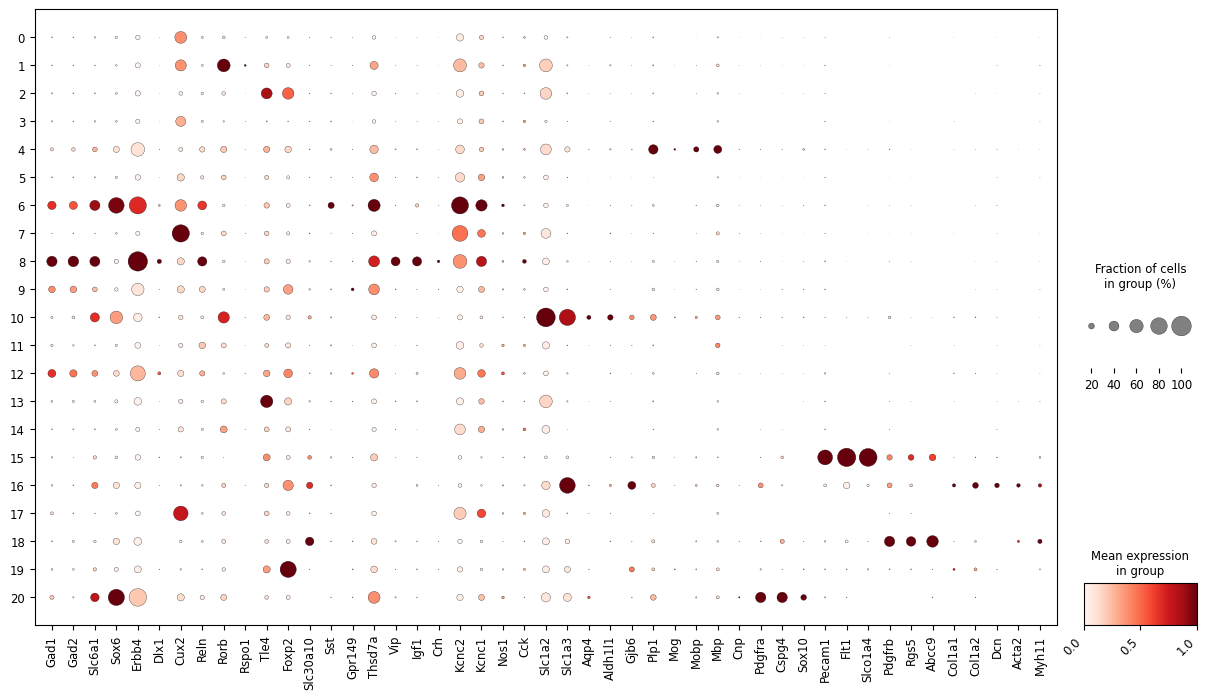

In [ ]:
from utils.annotation import plot_marker_genes

# Plot marker genes
plot_marker_genes(adata, marker_genes=MARKER_GENES, save_dir=PLOTS_DIR)

In [ ]:
# Import annotation functions from utils
from utils.annotation import assign_major_celltypes_by_scores, MAJOR_LABELS

# Run two-stage cell-level annotation
print("\n" + "="*60)
print("CELL TYPE ANNOTATION")
print("="*60)

assign_major_celltypes_by_scores(
    adata,
    margin=ANNOTATION_PARAMS['margin'],
    marker_genes=MARKER_GENES,
    major_labels=MAJOR_LABELS
)

# Show initial distribution
print("\nInitial cell type distribution:")
print(adata.obs['celltype'].value_counts().sort_index())

# Show annotation confidence
print("\nAnnotation confidence:")
conf_counts = adata.obs['annotation_confidence'].value_counts()
for conf, count in conf_counts.items():
    pct = count / len(adata) * 100
    print(f"  {conf}: {count:,} cells ({pct:.1f}%)")

# Show low-confidence cell types (to identify problematic assignments)
low_conf_mask = adata.obs['annotation_confidence'] == 'low'
if low_conf_mask.sum() > 0:
    print(f"\nLow-confidence cell type distribution:")
    low_conf_types = adata.obs.loc[low_conf_mask, 'celltype'].value_counts()
    for ct, count in low_conf_types.items():
        pct = count / low_conf_mask.sum() * 100
        print(f"  {ct}: {count:,} ({pct:.1f}%)")



CELL TYPE ANNOTATION
Stage 1: Assigning major cell types...


/Users/melissadu/Documents/projects/tsai-lab-scrna/.conductor/manama/utils/annotation.py:204: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['Endo' 'Oligo' 'Oligo' ... 'Excit' 'Inhib' 'Excit']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  adata.obs.loc[confident, "celltype"] = winners[confident]
/Users/melissadu/Documents/projects/tsai-lab-scrna/.conductor/manama/utils/annotation.py:205: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['Endo' 'Oligo' 'Oligo' ... 'Excit' 'Inhib' 'Excit']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  adata.obs.loc[confident, "celltype_detail"] = winners[confident]


  ✓ High confidence: 11,766 cells (72.7%)
  ✓ Low confidence: 4,422 cells (27.3%)
  ✓ Total assigned: 16,188 cells (100%)

Stage 2: Refining neuronal subtypes...
  Excit: 5,526 high confidence, 1,104 low confidence subtypes (6,630 total)
  Inhib: 2,542 high confidence, 486 low confidence subtypes (3,028 total)

✓ Final cell type distribution:
  Excit: 6,630
  Inhib: 3,028
  OPC: 2,693
  Astro: 1,504
  Oligo: 942
  Micro: 377
  VLMC: 369
  Endo: 247
  Peri: 230
  SMC: 168

Initial cell type distribution:
celltype
Astro    1504
Endo      247
Excit    6630
Inhib    3028
Micro     377
OPC      2693
Oligo     942
Peri      230
SMC       168
VLMC      369
Name: count, dtype: int64

Annotation confidence:
  high: 10,735 cells (66.3%)
  low: 5,453 cells (33.7%)

Low-confidence cell type distribution:
  OPC: 2,621 (48.1%)
  Excit: 1,104 (20.2%)
  Inhib: 486 (8.9%)
  VLMC: 315 (5.8%)
  Micro: 298 (5.5%)
  Astro: 252 (4.6%)
  Peri: 132 (2.4%)
  SMC: 117 (2.1%)
  Oligo: 114 (2.1%)
  Endo: 14 (0.3%


RE-CLUSTERING NEURONAL SUBTYPES

Neurons to re-cluster:
  Excitatory: 6,630 cells
  Inhibitory: 3,028 cells


/opt/homebrew/Cellar/python@3.12/3.12.12/Frameworks/Python.framework/Versions/3.12/lib/python3.12/functools.py:912: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)
/Users/melissadu/Documents/projects/tsai-lab-scrna/.conductor/manama/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/melissadu/Documents/projects/tsai-lab-scrna/.conductor/manama/utils/processing.py:186: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=float(res), key_added=key, directed=False)


Chosen Leiden resolution: 0.2

  Detected 7 excitatory subtypes: ExN_L2-3, ExN_L4, ExN_L5_IT, ExN_L5_PT, ExN_L6_CT, ExN_L6_IT, ExN_L6b
  Using cluster-based assignment (respects UMAP structure)
  Assigned subtypes to 2,310 cells across 4 confident clusters
  4,320 cells in uncertain clusters remain as 'Excit'
  Subtype distribution:
    Excit: 4,320
    ExN_L6b: 1,766
    ExN_L6_CT: 337
    ExN_L5_PT: 133
    ExN_L2-3: 74

  UMAP for excit (Leiden clusters):


/Users/melissadu/Documents/projects/tsai-lab-scrna/.conductor/manama/utils/recluster.py:89: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cluster_scores = sub_full.obs.loc[cells_to_assign].groupby(cluster_key)[score_cols].median()


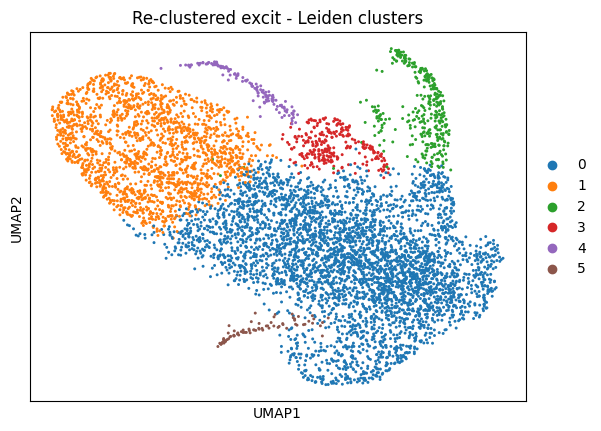

  Saved: plots/notebook3/reclustering/umap_excit.png

  UMAP for excit (Cell types):


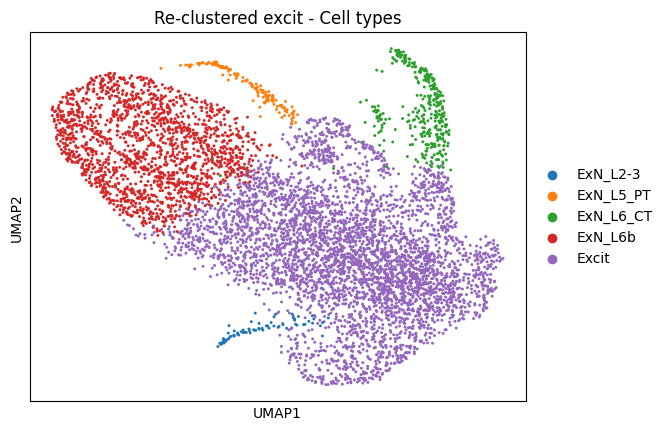

  Saved: plots/notebook3/reclustering/umap_excit_celltype.png
  Saved: plots/notebook3/reclustering/subset_excit.h5ad


/opt/homebrew/Cellar/python@3.12/3.12.12/Frameworks/Python.framework/Versions/3.12/lib/python3.12/functools.py:912: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


Chosen Leiden resolution: 0.9

  Detected 5 inhibitory subtypes: InN_SST, InN_VIP, InN_PVALB, InN_RELN, InN_CCK
  Using cluster-based assignment (respects UMAP structure)
  Assigned subtypes to 2,507 cells across 13 confident clusters
  521 cells in uncertain clusters remain as 'Inhib'
  Subtype distribution:
    InN_VIP: 1,132
    InN_CCK: 617
    InN_PVALB: 595
    Inhib: 521
    InN_SST: 163

  UMAP for inhib (Leiden clusters):


/Users/melissadu/Documents/projects/tsai-lab-scrna/.conductor/manama/utils/recluster.py:89: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cluster_scores = sub_full.obs.loc[cells_to_assign].groupby(cluster_key)[score_cols].median()


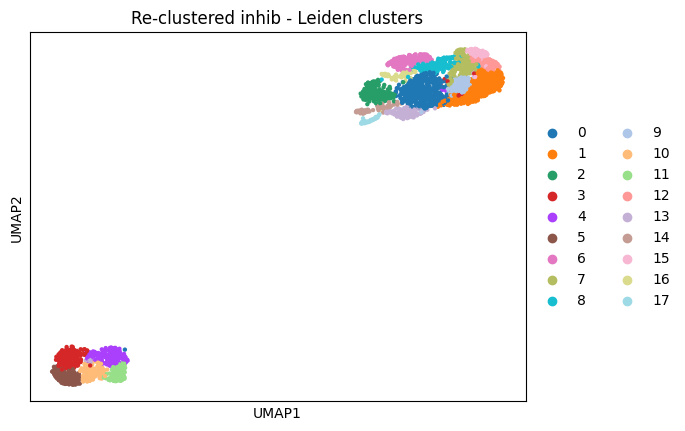

  Saved: plots/notebook3/reclustering/umap_inhib.png

  UMAP for inhib (Cell types):


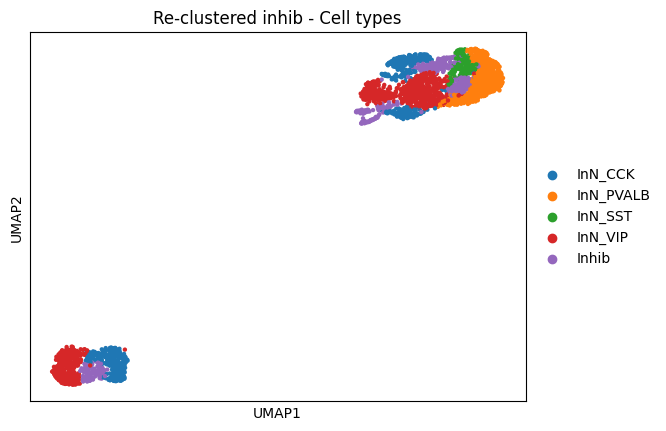

  Saved: plots/notebook3/reclustering/umap_inhib_celltype.png
  Saved: plots/notebook3/reclustering/subset_inhib.h5ad

✓ Re-clustering complete!
  leiden_excit: 6 clusters
  leiden_inhib: 18 clusters

Final cell type distribution (with subtypes):
celltype
Astro        1504
Endo          247
ExN_L2-3       74
ExN_L5_PT     133
ExN_L6_CT     337
ExN_L6b      1766
Excit        4320
InN_CCK       617
InN_PVALB     595
InN_SST       163
InN_VIP      1132
Inhib         521
Micro         377
OPC          2693
Oligo         942
Peri          230
SMC           168
VLMC          369
Name: count, dtype: int64


In [ ]:
# Import and run re-clustering if enabled
# INCLUDE HEATMAP FOR INDIVIDUAL CELL ANNOTATIONS 

from utils.recluster import recluster_excit_inhib

if RECLUSTERING_PARAMS['enable']:
    print("\n" + "="*60)
    print("RE-CLUSTERING NEURONAL SUBTYPES")
    print("="*60)
    
    ct = adata.obs['celltype'].astype(str)
    # Count only broad categories (Excit, Inhib) - subtypes assigned during re-clustering
    n_excit = (ct == 'Excit').sum()
    n_inhib = (ct == 'Inhib').sum()
    
    print(f"\nNeurons to re-cluster:")
    print(f"  Excitatory: {n_excit:,} cells")
    print(f"  Inhibitory: {n_inhib:,} cells")
    
    if n_excit < 100 and n_inhib < 100:
        print("\n⚠️  Too few neurons (<100 each). Skipping re-clustering.")
    else:
        recluster_dir = PLOTS_DIR / 'reclustering'
        recluster_dir.mkdir(exist_ok=True)
        
        adata = recluster_excit_inhib(
            adata,
            save_dir=recluster_dir,
            auto_resolution=RECLUSTERING_PARAMS['auto_resolution'],
            resolution_grid=RECLUSTERING_PARAMS['resolution_grid'],
            n_top_genes=RECLUSTERING_PARAMS['n_top_genes'],
            n_pcs=RECLUSTERING_PARAMS['n_pcs'],
            n_neighbors=RECLUSTERING_PARAMS['n_neighbors'],
            random_state=RECLUSTERING_PARAMS['random_state'],
            write_h5ad=RECLUSTERING_PARAMS['write_h5ad'],
            use_cluster_assignment=RECLUSTERING_PARAMS['use_cluster_assignment'],
            confidence_margin=RECLUSTERING_PARAMS['confidence_margin'],
            marker_genes=MARKER_GENES,
        )
        
        print("\n✓ Re-clustering complete!")
        if 'leiden_excit' in adata.obs:
            print(f"  leiden_excit: {adata.obs['leiden_excit'].nunique() - 1} clusters")
        if 'leiden_inhib' in adata.obs:
            print(f"  leiden_inhib: {adata.obs['leiden_inhib'].nunique() - 1} clusters")
        
        print("\nFinal cell type distribution (with subtypes):")
        print(adata.obs['celltype'].value_counts().sort_index())
else:
    print("\n⚠️  Re-clustering disabled. Set RECLUSTERING_PARAMS['enable'] = True to run.")

## Stage 8.5: Advanced Neuron Subtype Re-clustering (Optional)

Re-cluster excitatory and inhibitory neurons separately to discover finer-grained neuronal subtypes.

## Visualization

Plot annotated cell types on UMAP and composition heatmap.

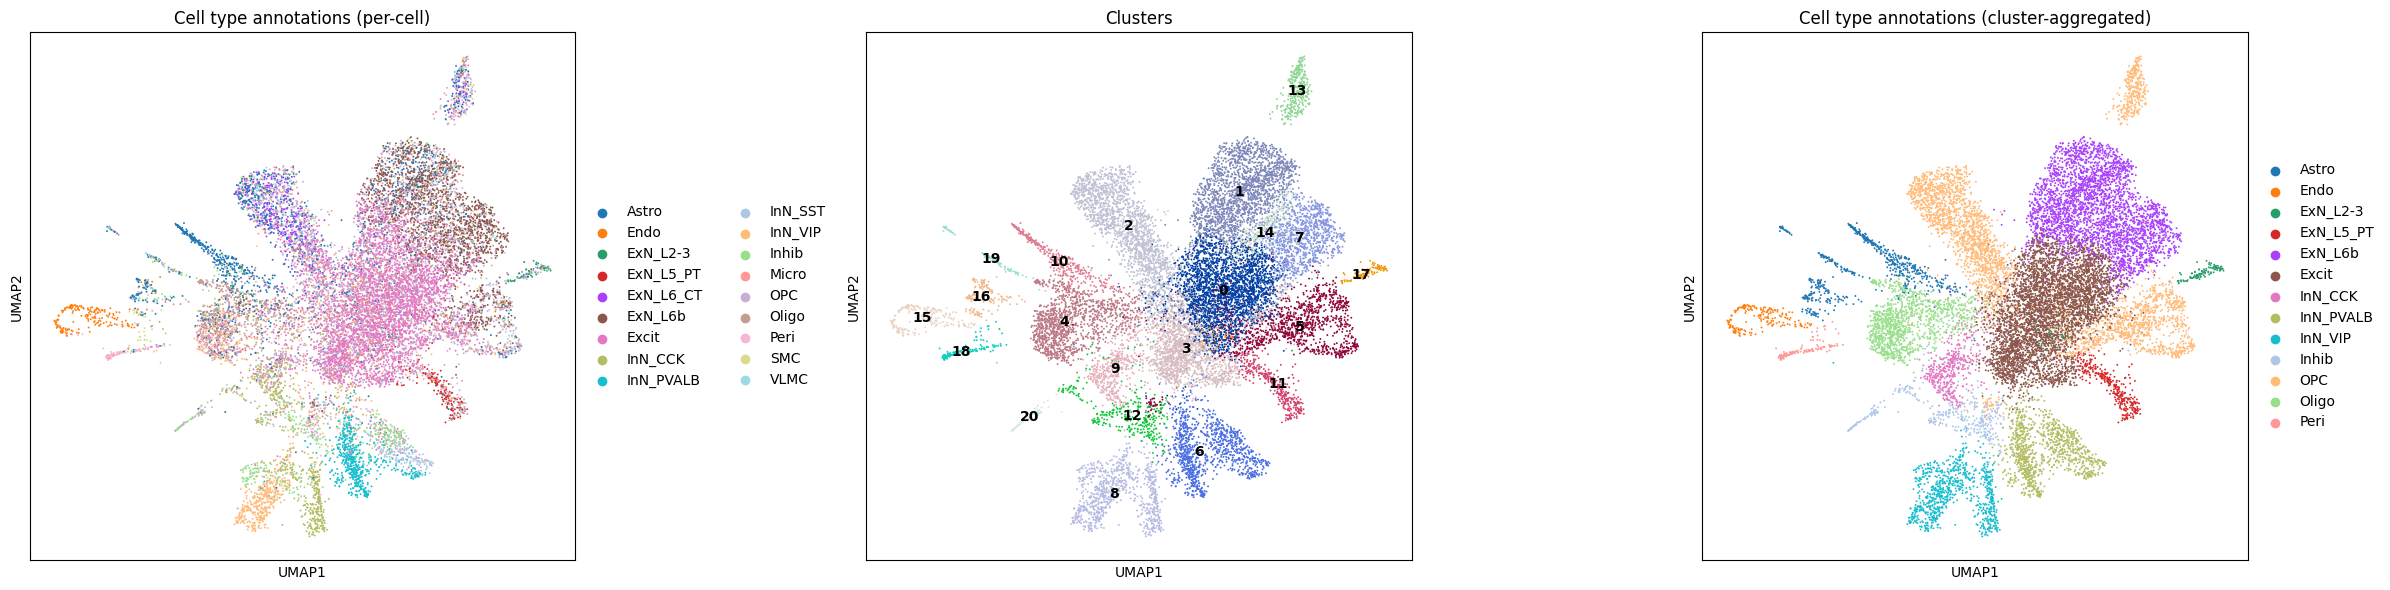

✓ Saved: plots/notebook3/celltype_umap.png


In [ ]:
# Plot annotated cell types on UMAP
# Create cluster-aggregated labels with mixed cluster detection
from utils.annotation import create_cluster_aggregated_labels

# Identify mixed clusters (purity < 60%)
mixed_clusters = create_cluster_aggregated_labels(
    adata, 
    celltype_col='celltype', 
    cluster_col='leiden',
    purity_threshold=0.60
)

# Create 3-panel figure: cell-level, clusters, cluster-aggregated
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

# Plot 1: Per-cell annotations (shows heterogeneity within clusters)
sc.pl.umap(
    adata,
    color='celltype',
    legend_loc='right margin',
    title='Cell type annotations (per-cell)',
    ax=axes[0],
    show=False
)

# Plot 2: Clusters with labels
sc.pl.umap(
    adata,
    color='leiden',
    legend_loc='on data',
    title='Clusters',
    ax=axes[1],
    show=False
)

# Plot 3: Cluster-level aggregated view (dominant cell type per cluster, with "Mixed" label)
sc.pl.umap(
    adata,
    color='celltype_cluster',
    legend_loc='right margin',
    title='Cell type annotations (cluster-aggregated, Mixed if <60%)',
    ax=axes[2],
    show=False
)

plt.tight_layout()
plt.savefig(PLOTS_DIR / 'celltype_umap.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Saved: {PLOTS_DIR}/celltype_umap.png")

# Additional visualization: Cluster purity heatmap
if mixed_clusters:
    print(f"\n{'='*60}")
    print("MIXED CLUSTER VISUALIZATION")
    print(f"{'='*60}")
    
    # Plot cluster purity
    fig, ax = plt.subplots(figsize=(10, 6))
    purity_by_cluster = adata.obs.groupby('leiden')['cluster_purity'].first().sort_index()
    colors = ['red' if p <= 0.60 else 'green' for p in purity_by_cluster]
    
    purity_by_cluster.plot(kind='bar', ax=ax, color=colors)
    ax.axhline(y=0.60, color='black', linestyle='--', label='Purity threshold (60%)')
    ax.set_xlabel('Cluster')
    ax.set_ylabel('Cluster purity (dominant cell type proportion)')
    ax.set_title('Cluster purity analysis (Red = Mixed, Green = Pure)')
    ax.legend()
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / 'cluster_purity.png', dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✓ Saved: {PLOTS_DIR}/cluster_purity.png")
    
    # Highlight mixed clusters on UMAP
    fig, ax = plt.subplots(figsize=(10, 8))
    adata.obs['is_mixed_cluster'] = adata.obs['celltype_cluster'] == 'Mixed'
    sc.pl.umap(
        adata,
        color='is_mixed_cluster',
        title='Mixed clusters (heterogeneous, purity <60%)',
        palette=['lightgray', 'red'],
        ax=ax,
        show=False
    )
    plt.savefig(PLOTS_DIR / 'mixed_clusters_umap.png', dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✓ Saved: {PLOTS_DIR}/mixed_clusters_umap.png")
    
    # Save mixed cluster summary to CSV
    mixed_summary = adata.obs[adata.obs['is_mixed_cluster']].groupby('leiden').agg({
        'celltype_cluster_top_types': 'first',
        'cluster_purity': 'first',
        'orig.ident': 'count'  # cell count
    }).rename(columns={'orig.ident': 'n_cells'})
    mixed_summary.to_csv(PLOTS_DIR / 'mixed_clusters_summary.csv')
    print(f"✓ Saved: {PLOTS_DIR}/mixed_clusters_summary.csv")
else:
    print("\n✓ All clusters are pure (>60% dominant cell type)!")

### 🔍 Optional: Re-analyze Mixed Clusters

If you have **mixed clusters** (purity < 60%), you have several options:

#### **Option 1: Extract and Re-cluster Mixed Clusters** (Recommended)

Extract cells from mixed clusters and perform higher-resolution clustering to identify sub-populations:

```python
if mixed_clusters:
    # Extract mixed cluster cells
    mixed_mask = adata.obs['is_mixed_cluster']
    adata_mixed = adata[mixed_mask].copy()
    
    print(f"Extracted {adata_mixed.n_obs:,} cells from {len(mixed_clusters)} mixed clusters")
    
    # Re-cluster at higher resolution
    sc.pp.neighbors(adata_mixed, n_neighbors=15, n_pcs=30)
    sc.tl.leiden(adata_mixed, resolution=1.0)  # Higher resolution
    sc.tl.umap(adata_mixed)
    
    # Visualize
    sc.pl.umap(adata_mixed, color=['leiden', 'celltype'], ncols=2)
    
    # Re-annotate with marker genes
    # ... (run annotation again on adata_mixed)
```

#### **Option 2: Mark as Doublets** (if appropriate)

If mixed clusters have high doublet scores and are positioned between cell type regions:

```python
# Check doublet scores in mixed clusters
mixed_doublet_scores = adata.obs[adata.obs['is_mixed_cluster']]['doublet_score']
print(f"Mean doublet score in mixed clusters: {mixed_doublet_scores.mean():.3f}")
print(f"Mean doublet score overall: {adata.obs['doublet_score'].mean():.3f}")

# If significantly higher, consider filtering
if mixed_doublet_scores.mean() > adata.obs['doublet_score'].mean() + 0.1:
    print("Mixed clusters likely contain doublets - consider filtering")
```

#### **Option 3: Accept as Transitional/Intermediate States**

Some mixed clusters may represent biologically relevant transitional states or intermediate cell populations. Investigate marker genes to determine if this is the case.

#### **Option 4: Adjust Clustering Parameters**

Go back to **Notebook 2** and try different clustering resolutions to see if mixed clusters can be better separated.


In [ ]:
# Optional: Execute this cell to re-analyze mixed clusters
# Set ANALYZE_MIXED = True to run

ANALYZE_MIXED = False  # 🔧 Set to True to analyze mixed clusters

if ANALYZE_MIXED and mixed_clusters:
    print(f"\n{'='*60}")
    print("RE-ANALYZING MIXED CLUSTERS")
    print(f"{'='*60}")
    
    # Extract mixed cluster cells
    mixed_mask = adata.obs['is_mixed_cluster']
    adata_mixed = adata[mixed_mask].copy()
    
    print(f"\nExtracted {adata_mixed.n_obs:,} cells from {len(mixed_clusters)} mixed clusters")
    print(f"Cell types present: {adata_mixed.obs['celltype'].value_counts().to_dict()}")
    
    # Check doublet scores
    mixed_doublet_mean = adata_mixed.obs['doublet_score'].mean()
    overall_doublet_mean = adata.obs['doublet_score'].mean()
    
    print(f"\nDoublet score analysis:")
    print(f"  Mixed clusters: {mixed_doublet_mean:.3f}")
    print(f"  Overall: {overall_doublet_mean:.3f}")
    print(f"  Difference: {mixed_doublet_mean - overall_doublet_mean:.3f}")
    
    if mixed_doublet_mean > overall_doublet_mean + 0.1:
        print("  ⚠️ Mixed clusters show elevated doublet scores - may be doublets")
    else:
        print("  ✓ Doublet scores normal - likely genuine heterogeneous populations")
    
    # Re-cluster at higher resolution
    print("\nRe-clustering at higher resolution...")
    sc.pp.neighbors(adata_mixed, n_neighbors=15, n_pcs=30, random_state=0)
    sc.tl.leiden(adata_mixed, resolution=1.2, random_state=0, key_added='leiden_recluster')
    sc.tl.umap(adata_mixed, random_state=0)
    
    print(f"  New clusters: {adata_mixed.obs['leiden_recluster'].nunique()}")
    
    # Visualize re-clustering results
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Row 1: Original clusters, cell types, doublet scores
    sc.pl.umap(adata_mixed, color='leiden', title='Original clusters (in full data)', 
               ax=axes[0, 0], show=False)
    sc.pl.umap(adata_mixed, color='celltype', title='Cell type annotations',
               ax=axes[0, 1], show=False)
    sc.pl.umap(adata_mixed, color='doublet_score', title='Doublet scores',
               ax=axes[0, 2], show=False, cmap='Reds')
    
    # Row 2: New clusters, composition analysis
    sc.pl.umap(adata_mixed, color='leiden_recluster', title='Re-clustered (higher resolution)',
               ax=axes[1, 0], show=False, legend_loc='on data')
    
    # Composition of new clusters
    composition_mixed = pd.crosstab(
        adata_mixed.obs['leiden_recluster'],
        adata_mixed.obs['celltype'],
        normalize='index'
    )
    
    # Heatmap of composition
    import seaborn as sns
    sns.heatmap(composition_mixed, annot=True, fmt='.2f', cmap='YlOrRd',
                ax=axes[1, 1], cbar_kws={'label': 'Proportion'})
    axes[1, 1].set_title('Cell type composition of new clusters')
    axes[1, 1].set_xlabel('Cell type')
    axes[1, 1].set_ylabel('New cluster')
    
    # Bar plot of cluster sizes
    cluster_sizes = adata_mixed.obs['leiden_recluster'].value_counts().sort_index()
    axes[1, 2].bar(range(len(cluster_sizes)), cluster_sizes.values)
    axes[1, 2].set_xlabel('New cluster')
    axes[1, 2].set_ylabel('Number of cells')
    axes[1, 2].set_title('Cluster sizes after re-clustering')
    axes[1, 2].set_xticks(range(len(cluster_sizes)))
    axes[1, 2].set_xticklabels(cluster_sizes.index)
    
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / 'mixed_clusters_reanalysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    print(f"\n✓ Saved: {PLOTS_DIR}/mixed_clusters_reanalysis.png")
    
    # Analyze new cluster purity
    dominant_mixed = composition_mixed.idxmax(axis=1)
    dominant_prop_mixed = composition_mixed.max(axis=1)
    
    print(f"\n{'='*60}")
    print("NEW CLUSTER PURITY AFTER RE-CLUSTERING")
    print(f"{'='*60}")
    for cluster_id in composition_mixed.index:
        purity = dominant_prop_mixed[cluster_id]
        status = "✓ Pure" if purity > 0.60 else "⚠️ Still mixed"
        print(f"Cluster {cluster_id}: {dominant_mixed[cluster_id]} ({purity*100:.1f}%) - {status}")
    
    improved = (dominant_prop_mixed > 0.60).sum()
    total = len(dominant_prop_mixed)
    print(f"\nResult: {improved}/{total} clusters are now pure (>{60}%)")
    
    # Save re-clustered data
    adata_mixed.write_h5ad(PLOTS_DIR / 'mixed_clusters_reclustered.h5ad')
    print(f"\n✓ Saved re-clustered data: {PLOTS_DIR}/mixed_clusters_reclustered.h5ad")
    
    print("\n💡 Next steps:")
    print("  1. If purity improved: manually inspect marker genes for new clusters")
    print("  2. If still mixed: likely doublets or transitional states")
    print("  3. Consider filtering these cells or marking for separate analysis")
    
elif ANALYZE_MIXED and not mixed_clusters:
    print("✓ No mixed clusters to analyze - all clusters are pure!")
else:
    print("⏭️  Skipping mixed cluster re-analysis (set ANALYZE_MIXED = True to run)")


In [ ]:
# Print top markers for unlabeled (nan) clusters
import pandas as pd
from pathlib import Path

# Find clusters with nan celltype
unlabeled_clusters = adata.obs.groupby('leiden')['celltype'].apply(
    lambda x: pd.isna(x).all() or (x.astype(str) == 'nan').all()
)
unlabeled_cluster_ids = unlabeled_clusters[unlabeled_clusters].index.tolist()

if unlabeled_cluster_ids:
    print("="*60)
    print(f"TOP MARKERS FOR UNLABELED CLUSTERS ({len(unlabeled_cluster_ids)} clusters)")
    print("="*60)
    
    # Read the markers CSV file
    markers_file = Path('plots/top_markers_by_cluster.csv')
    if markers_file.exists():
        # Read CSV - it has a wide format with Cluster_X_genes and Cluster_X_scores columns
        markers_df = pd.read_csv(markers_file)
        
        for cluster_id in unlabeled_cluster_ids:
            cluster_num = int(cluster_id) if isinstance(cluster_id, str) else cluster_id
            genes_col = f'Cluster_{cluster_num}_genes'
            scores_col = f'Cluster_{cluster_num}_scores'
            
            if genes_col in markers_df.columns and scores_col in markers_df.columns:
                # Extract genes and scores for this cluster
                genes = markers_df[genes_col].dropna().tolist()
                scores = markers_df[scores_col].dropna().tolist()
                
                # Create pairs and sort by score (descending)
                gene_scores = list(zip(genes, scores))
                gene_scores.sort(key=lambda x: float(x[1]) if pd.notna(x[1]) else -float('inf'), reverse=True)
                
                print(f"\nCluster {cluster_num} (unlabeled):")
                print(f"  Top 10 markers:")
                for i, (gene, score) in enumerate(gene_scores[:10], 1):
                    print(f"    {i:2d}. {gene:15s} (score: {float(score):.2f})")
            else:
                print(f"\nCluster {cluster_num}: No marker data found")
    else:
        print(f"\n⚠️  Marker file not found: {markers_file}")
        print("   Run Notebook 2 to generate marker genes.")
else:
    print("\n✓ All clusters are labeled - no unlabeled clusters found!")



✓ All clusters are labeled - no unlabeled clusters found!


/var/folders/tf/f0_f53l11hq_9x5t0_hxr66h0000gn/T/ipykernel_56998/1663263870.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  unlabeled_clusters = adata.obs.groupby('leiden')['celltype'].apply(


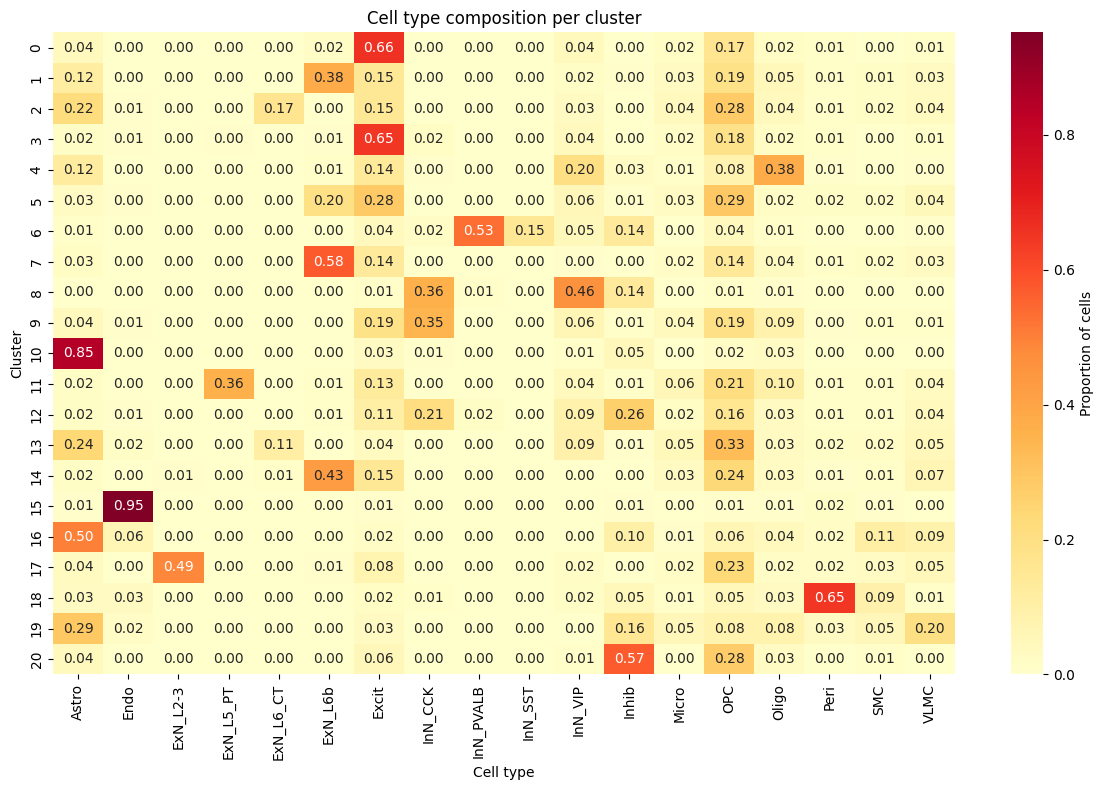

✓ Saved: plots/notebook3/composition_heatmap.png

Dominant cell type per cluster:
  Cluster 0: Excit (66.0%)
  Cluster 1: ExN_L6b (38.0%)
  Cluster 2: OPC (28.2%)
  Cluster 3: Excit (64.9%)
  Cluster 4: Oligo (37.8%)
  Cluster 5: OPC (28.8%)
  Cluster 6: InN_PVALB (53.4%)
  Cluster 7: ExN_L6b (57.6%)
  Cluster 8: InN_VIP (46.1%)
  Cluster 9: InN_CCK (34.8%)
  Cluster 10: Astro (84.8%)
  Cluster 11: ExN_L5_PT (36.2%)
  Cluster 12: Inhib (26.4%)
  Cluster 13: OPC (32.6%)
  Cluster 14: ExN_L6b (42.8%)
  Cluster 15: Endo (95.2%)
  Cluster 16: Astro (50.0%)
  Cluster 17: ExN_L2-3 (48.6%)
  Cluster 18: Peri (64.8%)
  Cluster 19: Astro (29.2%)
  Cluster 20: Inhib (56.9%)


In [ ]:
# Create composition heatmap showing cell type distribution per cluster
composition = pd.crosstab(
    adata.obs['leiden'],
    adata.obs['celltype'],
    normalize='index'  # Normalize by cluster (rows sum to 1)
)

plt.figure(figsize=(12, 8))
sns.heatmap(
    composition,
    annot=True,
    fmt='.2f',
    cmap='YlOrRd',
    cbar_kws={'label': 'Proportion of cells'}
)
plt.title('Cell type composition per cluster')
plt.xlabel('Cell type')
plt.ylabel('Cluster')
plt.tight_layout()
plt.savefig(PLOTS_DIR / 'composition_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Saved: {PLOTS_DIR}/composition_heatmap.png")

# Identify dominant cell type per cluster
dominant = composition.idxmax(axis=1)
dominant_prop = composition.max(axis=1)

print("\nDominant cell type per cluster:")
for cluster, (celltype, prop) in enumerate(zip(dominant, dominant_prop)):
    print(f"  Cluster {cluster}: {celltype} ({prop*100:.1f}%)")

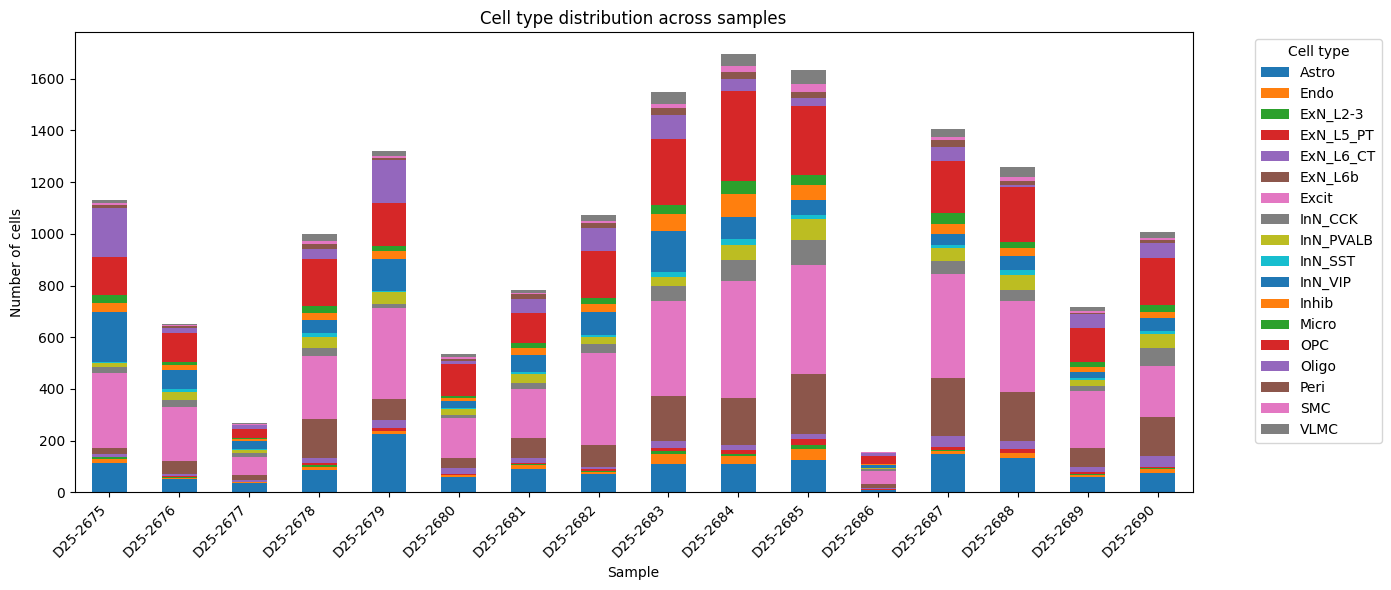

✓ Saved: plots/notebook3/celltype_distribution.png


In [ ]:
# Plot cell type distribution across samples
celltype_by_sample = pd.crosstab(
    adata.obs['orig.ident'],
    adata.obs['celltype']
)

fig, ax = plt.subplots(figsize=(14, 6))
celltype_by_sample.plot(kind='bar', stacked=True, ax=ax)
plt.title('Cell type distribution across samples')
plt.xlabel('Sample')
plt.ylabel('Number of cells')
plt.xticks(rotation=45, ha='right')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Cell type')
plt.tight_layout()
plt.savefig(PLOTS_DIR / 'celltype_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Saved: {PLOTS_DIR}/celltype_distribution.png")

### 🎛️ Parameter Tuning Guide: Annotation Quality

Review the UMAP and composition heatmap above. How did the annotation perform?

---

#### **📊 Cell Type Distribution**

<details>
<summary><b>&gt;20% cells are "Unlabeled"</b></summary>

**Diagnosis:** ⚠️ Low confidence in many cell type assignments

**Possible causes:**
1. Margin too stringent
2. Marker genes not appropriate for your tissue
3. Missing cell type-specific markers

**Actions:**

**Approach 1: Lower confidence margin**
```python
# In Cell 3, update:
ANNOTATION_PARAMS['margin'] = 0.03  # Lower from 0.05 (less stringent)
```

**Approach 2: Add tissue-specific markers**
```python
# Add more specific markers to MARKER_GENES dictionary:
MARKER_GENES['ExN_L2-4'] = ["Cux1", "Cux2", "Satb2"]
MARKER_GENES['ExN_L5'] = ["Bcl11b", "Fezf2"]
MARKER_GENES['InN_SST'] = ["Sst", "Npy"]
MARKER_GENES['InN_VIP'] = ["Vip", "Cck"]
```

**Approach 3: Use cluster-level annotation** (less affected by dropout)
```python
ANNOTATION_PARAMS['label_mode'] = 'cluster'
ANNOTATION_PARAMS['cluster_agg'] = 'median'
```

**Then:** Re-run from Cell 5
</details>

<details>
<summary><b>Most clusters are a single cell type</b> (e.g., all 15 clusters annotated as "Excit")</summary>

**Diagnosis:** ⚠️ Markers not specific enough

**Problems:**
- Cannot distinguish subtypes
- Over-clustering without biological meaning

**Actions:**

**Approach 1: Add more specific subtype markers**
```python
# Replace broad markers with specific ones:
MARKER_GENES = {
    "ExN_L2-3": ["Cux1", "Cux2", "Rorb"],
    "ExN_L4": ["Rorb", "Scnn1a"],
    "ExN_L5": ["Bcl11b", "Fezf2", "Foxp2"],
    "ExN_L6": ["Tbr1", "Foxp2"],
    "InN_Pvalb": ["Pvalb", "Gabra1"],
    "InN_Sst": ["Sst", "Npy"],
    "InN_Vip": ["Vip", "Cck"],
    # ... keep glia markers ...
}
```

**Approach 2: Decrease clustering resolution** (if subtypes don't exist)
- Go back to Notebook 2, Cell 4
- Lower resolution to get broader clusters

**Then:** Re-run from Cell 5 (this notebook) or from Notebook 2
</details>

<details>
<summary><b>One cluster has mixed cell types</b> (e.g., Cluster 5: 40% Excit, 30% Inhib, 30% Astro)</summary>

**Diagnosis:** ⚠️ Possible doublet cluster or under-clustering

**Investigation:**

1. **Check doublet scores:**
```python
# Add cell to check:
cluster_id = '5'
print("Doublet score distribution:")
print(adata[adata.obs['leiden'] == cluster_id].obs['doublet_score'].describe())
```

2. **Check if intermediate position on UMAP**
   - If positioned between major cell types → Likely doublets
   - If within a cell type region → Under-clustering

**Actions:**

**If doublets:**
- Go back to Notebook 1
- Lower doublet threshold:
```python
DOUBLET_PARAMS['manual_threshold'] = 0.30  # More stringent
```
- Re-run from Notebook 1, Stage 3

**If under-clustering:**
- Go back to Notebook 2
- Increase resolution:
```python
CLUSTERING_PARAMS['resolution'] = 1.0  # Higher
```
- Re-run from Notebook 2, Cell 10

**If transitional/intermediate state:** May be biological - investigate further
</details>

<details>
<summary><b>Annotation matches UMAP spatial organization</b></summary>

**Diagnosis:** ✅ Excellent - biologically coherent

**Observations to validate:**
- Similar cell types cluster together on UMAP
- Clear boundaries between cell types
- Cell type composition makes biological sense

**Quality checks:**
1. **Composition heatmap** - each cluster should be dominated by 1-2 cell types
2. **Expected proportions** - do cell type proportions match biology?
   - Brain: Mostly neurons (60-80%), some glia (20-40%)
   - Immune: Varied depending on tissue
   - Epithelial: Mostly epithelial cells with some stromal

**Action:** Proceed to export with confidence
</details>

---

#### **📊 Composition Heatmap Interpretation**

**Good patterns:**
- **Each cluster dominated by one cell type** (>60% one cell type)
- **Related cell types group together** (e.g., ExN_L2-4 and ExN_L5 in adjacent clusters)
- **Clear cluster identity**

**Problematic patterns:**
- **Cluster split evenly** between 2+ cell types → Under-clustering or doublets
- **Same cell type in many distant clusters** → Over-clustering
- **High "Unlabeled" in all clusters** → Markers not working

---

#### **💡 Troubleshooting Decision Tree**

```
High unlabeled (>20%)?
├─ Yes: Lower margin OR add more specific markers
└─ No: Check composition heatmap
    ├─ Clean (each cluster = 1 cell type): ✅ Done!
    ├─ Mixed clusters:
    │   ├─ Intermediate on UMAP: Doublets → Notebook 1
    │   └─ Within cell type region: Under-clustering → Notebook 2
    └─ All clusters same type:
        ├─ Biological: ✅ Done (homogeneous sample)
        └─ Technical: Add subtype markers OR decrease resolution
```

---

#### **💡 What Makes Good Annotations**

**Confidence indicators:**
1. **Spatial coherence** - same cell type clusters together on UMAP
2. **Marker expression** - markers specifically expressed in assigned cell types
3. **Biological plausibility** - cell type proportions make sense
4. **Cluster purity** - each cluster mostly one cell type (>70%)

**Next steps after annotation:**
1. Validate with known markers (plot specific genes on UMAP)
2. Check differential expression between conditions
3. Investigate cell type-specific changes
4. Export for downstream analysis

## Stage 9: Final Export

Save annotated data and metadata for downstream analysis.

In [ ]:
# Store parameters used
adata.uns['pipeline_params']['notebook'] = '3_annotation_export'
adata.uns['pipeline_params']['annotation'] = ANNOTATION_PARAMS
adata.uns['pipeline_params']['marker_genes'] = {k: v for k, v in MARKER_GENES.items()}

# Save annotated data
output_file = 'outputs/annotated_data.h5ad'
adata.write(output_file)

print("\n" + "="*60)
print("SAVING FINAL OUTPUT")
print("="*60)
print(f"✓ Saved: {output_file}")
print(f"  Size: {Path(output_file).stat().st_size / 1e6:.1f} MB")
print(f"  Cells: {adata.n_obs:,}")
print(f"  Genes: {adata.n_vars:,}")


SAVING FINAL OUTPUT
✓ Saved: outputs/annotated_data.h5ad
  Size: 540.5 MB
  Cells: 16,188
  Genes: 2,019


In [ ]:
# Export cell metadata to CSV
metadata_cols = [
    'leiden',
    'celltype',
    'orig.ident',
    'Genotype',
    'Sex',
    'n_genes_by_counts',
    'total_counts',
    'percent_mt',
    'doublet_score',
]

# Only include columns that exist
existing_cols = [c for c in metadata_cols if c in adata.obs.columns]
adata.obs[existing_cols].to_csv('outputs/cell_metadata.csv')

print(f"✓ Saved: outputs/cell_metadata.csv")
print(f"  Columns: {existing_cols}")

✓ Saved: outputs/cell_metadata.csv
  Columns: ['leiden', 'celltype', 'orig.ident', 'Genotype', 'Sex', 'n_genes_by_counts', 'total_counts', 'percent_mt', 'doublet_score']


In [ ]:
# Create analysis summary
summary_data = {
    'Metric': [
        'Total cells',
        'Total genes',
        'Clusters',
        'Cell types',
        'Median genes/cell',
        'Median UMIs/cell',
        'Median MT%',
        'Samples',
    ],
    'Value': [
        f"{adata.n_obs:,}",
        f"{adata.n_vars:,}" if adata.raw is None else f"{adata.raw.n_vars:,}",
        adata.obs['leiden'].nunique(),
        adata.obs['celltype'].nunique(),
        f"{adata.obs['n_genes_by_counts'].median():.0f}",
        f"{adata.obs['total_counts'].median():.0f}",
        f"{adata.obs['percent_mt'].median():.2f}%",
        adata.obs['orig.ident'].nunique(),
    ]
}

summary_df = pd.DataFrame(summary_data)
summary_df.to_csv('outputs/analysis_summary.csv', index=False)

print("\n" + "="*60)
print("ANALYSIS SUMMARY")
print("="*60)
display(summary_df)

# Cell type distribution
print("\n" + "="*60)
print("CELL TYPE DISTRIBUTION")
print("="*60)
celltype_dist = adata.obs['celltype'].value_counts().sort_index()
print(celltype_dist)

# Save cell type counts
celltype_dist.to_csv('outputs/celltype_counts.csv', header=['count'])
print("\n✓ Saved: outputs/celltype_counts.csv")

# Cells per sample
print("\n" + "="*60)
print("CELLS PER SAMPLE")
print("="*60)
sample_counts = adata.obs['orig.ident'].value_counts().sort_index()
print(sample_counts)


ANALYSIS SUMMARY


,Metric,Value
0,Total cells,"16,188"
1,Total genes,"19,608"
2,Clusters,21
3,Cell types,18
4,Median genes/cell,1064
5,Median UMIs/cell,1716
6,Median MT%,0.19%
7,Samples,16



CELL TYPE DISTRIBUTION
celltype
Astro        1504
Endo          247
ExN_L2-3       74
ExN_L5_PT     133
ExN_L6_CT     337
ExN_L6b      1766
Excit        4320
InN_CCK       617
InN_PVALB     595
InN_SST       163
InN_VIP      1132
Inhib         521
Micro         377
OPC          2693
Oligo         942
Peri          230
SMC           168
VLMC          369
Name: count, dtype: int64

✓ Saved: outputs/celltype_counts.csv

CELLS PER SAMPLE
orig.ident
D25-2675    1130
D25-2676     653
D25-2677     269
D25-2678    1000
D25-2679    1320
D25-2680     537
D25-2681     783
D25-2682    1075
D25-2683    1550
D25-2684    1695
D25-2685    1633
D25-2686     157
D25-2687    1404
D25-2688    1257
D25-2689     718
D25-2690    1007
Name: count, dtype: int64


## Pipeline Complete! 🎉

### Output Files

**Main outputs:**
- `outputs/annotated_data.h5ad` - Annotated AnnData object (FINAL)
- `outputs/cell_metadata.csv` - Cell-level metadata
- `outputs/celltype_counts.csv` - Cell type distribution
- `outputs/analysis_summary.csv` - Pipeline summary statistics

**Plots:**
- `plots/notebook3/marker_genes_dotplot.png` - Marker gene expression
- `plots/notebook3/celltype_umap.png` - Cell types on UMAP
- `plots/notebook3/composition_heatmap.png` - Cluster composition
- `plots/notebook3/celltype_distribution.png` - Cell types per sample

### Next Steps

**Downstream analysis:**
1. **Differential expression** between conditions (e.g., E3 vs E4, Ctrl vs GENUS)
2. **Cell type proportions** analysis across groups
3. **Trajectory analysis** for developmental/temporal data
4. **Gene regulatory network** inference
5. **Integration** with other datasets

**Quality validation:**
1. Plot known markers on UMAP: `sc.pl.umap(adata, color=['Snap25', 'Gad1', 'Gfap'])`
2. Check cluster-specific markers: `sc.tl.rank_genes_groups(adata, 'celltype')`
3. Validate doublet removal: `sc.pl.umap(adata, color='doublet_score')`

**Further refinement:**
- Re-cluster neuronal subtypes (excitatory/inhibitory)
- Identify rare cell populations
- Integrate batch correction if needed

### Pipeline Parameters Used

All parameters are stored in `adata.uns['pipeline_params']` for reproducibility.

```python
# To access parameters:
print(adata.uns['pipeline_params'])
```